In [1]:
import sys
sys.path.append('../')
from fcc_utils import *

In [ ]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
from scipy.spatial.distance import pdist, cdist

In [3]:
%time hemato = sc.read('../inputs/mca_hemato.h5ad')

CPU times: user 11.5 s, sys: 1.97 s, total: 13.5 s
Wall time: 13.5 s


In [4]:
%time recipe_fcc(hemato, mito_names='mt-')
# see resulting AnnData contents
hemato

CPU times: user 28.5 s, sys: 8.85 s, total: 37.4 s
Wall time: 37.4 s


AnnData object with n_obs × n_vars = 45214 × 25411 
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'X_gf-icf'

In [5]:
%%time
sc.pp.scale(hemato, max_value=10)
sc.tl.pca(hemato, use_highly_variable=False, n_comps=500)

CPU times: user 5min 26s, sys: 11.1 s, total: 5min 37s
Wall time: 1min 4s


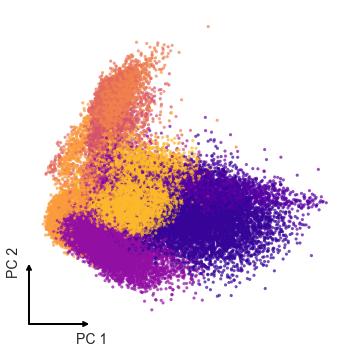

In [120]:
plot_IDs(hemato, use_rep='X_pca', obs_col='louvain_test', dim_name='PC', pt_size=10)

In [7]:
# create neighborhood graphs from PCA results for UMAP
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(hemato, n_neighbors=30, use_rep='X_pca', n_pcs=20, knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

CPU times: user 1min 6s, sys: 253 ms, total: 1min 6s
Wall time: 1min 6s


In [10]:
# perform Louvain clustering
%time sc.tl.louvain(hemato, resolution=1.0, key_added='louvain', adjacency=hemato.uns['neighbors']['connectivities'], random_state=18, copy=False)

CPU times: user 8.55 s, sys: 182 ms, total: 8.73 s
Wall time: 8.73 s


In [37]:
hemato.obs['batch']

index
BoneMarrowcKit_2.ACACCCCCATCTGTCGGT-4      BoneMarrowcKit_2
BoneMarrowcKit_2.TTCCGCCCATCTCCATCT-4      BoneMarrowcKit_2
BoneMarrowcKit_2.TTCCGCAAGCGGGTCGGT-4      BoneMarrowcKit_2
BoneMarrowcKit_2.ACACCCATGGCGGTCGGT-4      BoneMarrowcKit_2
BoneMarrowcKit_2.CGGCAGGCCTAGAACCTA-4      BoneMarrowcKit_2
                                                ...        
PeripheralBlood_3.CGCACCCCGACGAATAAA-8    PeripheralBlood_3
BoneMarrowcKit_3.CGAGTAGCTCAAGTCCCG-5      BoneMarrowcKit_3
BoneMarrow_5.GCGTCCAGATGGATCTCT-2              BoneMarrow_5
BoneMarrowcKit_2.CTCCATTTTAGGTGGATG-4      BoneMarrowcKit_2
BoneMarrowcKit_3.ATGCTTATTCCACATGAT-5      BoneMarrowcKit_3
Name: batch, Length: 45214, dtype: category
Categories (12, object): [BoneMarrow_1, BoneMarrow_4, BoneMarrow_5, BoneMarrowcKit_1, ..., PeripheralBlood_3, PeripheralBlood_4, PeripheralBlood_5, PeripheralBlood_6]

In [44]:
hemato.obs['louvain_test'] = 'cluster_' + hemato.obs['louvain'].astype(str)

In [11]:
%time sc.tl.umap(hemato)

CPU times: user 46.6 s, sys: 939 ms, total: 47.5 s
Wall time: 38.5 s


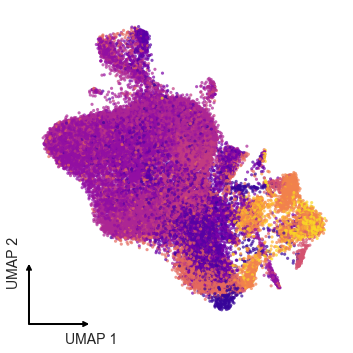

In [12]:
plot_IDs(hemato, use_rep='X_umap', obs_col='batch', dim_name='UMAP', pt_size=10)

In [13]:
%time sc.tl.tsne(hemato)

CPU times: user 14min 17s, sys: 4.02 s, total: 14min 21s
Wall time: 14min 21s


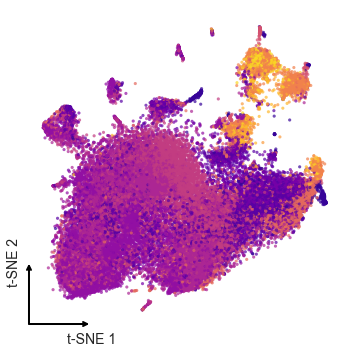

In [14]:
plot_IDs(hemato, use_rep='X_tsne', obs_col='batch', dim_name='t-SNE', pt_size=10)

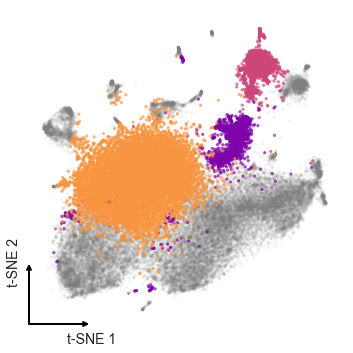

In [115]:
plot_IDs(hemato, use_rep='X_tsne', obs_col='louvain_test', IDs=['cluster_0', 'cluster_4', 'cluster_5'], dim_name='t-SNE', pt_size=10)

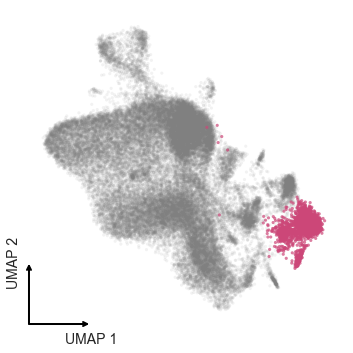

In [127]:
plot_IDs(hemato, use_rep='X_umap', obs_col='louvain_test', IDs=['cluster_4'], dim_name='UMAP', pt_size=10)

We can test the Euclidean distance preservation as follows:

In [53]:
# first, subsample to reasonable number of obs to get a quick idea of results
hemato_10k = sc.pp.subsample(hemato, n_obs=10000, random_state=18, copy=True)

In [54]:
hemato_10k

AnnData object with n_obs × n_vars = 10000 × 25411 
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'ranked_total_counts', 'norm_factor', 'louvain', 'louvain_test'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'X_gf-icf'

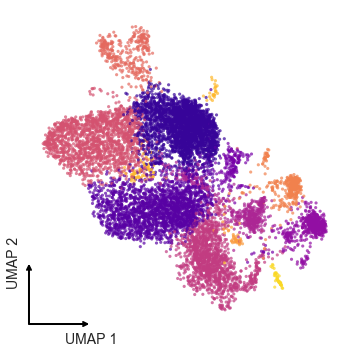

In [55]:
plot_IDs(hemato_10k, use_rep='X_umap', obs_col='louvain_test', dim_name='UMAP', pt_size=10)

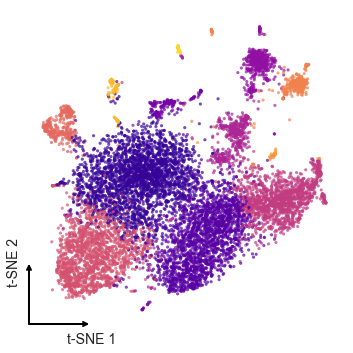

In [56]:
plot_IDs(hemato_10k, use_rep='X_tsne', obs_col='louvain_test', dim_name='t-SNE', pt_size=10)

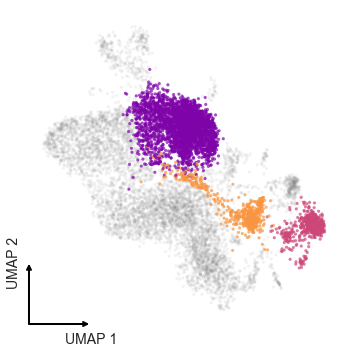

In [60]:
plot_IDs(hemato_10k, use_rep='X_umap', obs_col='louvain_test', dim_name='UMAP', pt_size=10, IDs = ['cluster_0', 'cluster_5', 'cluster_4'])

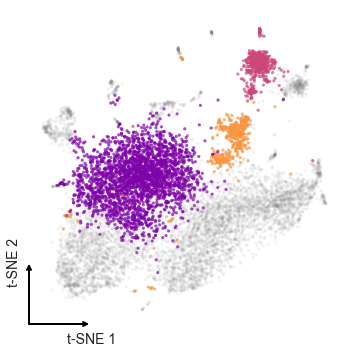

In [59]:
plot_IDs(hemato_10k, use_rep='X_tsne', obs_col='louvain_test', dim_name='t-SNE', pt_size=10, IDs = ['cluster_0', 'cluster_5', 'cluster_4'])

In [19]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

In [20]:
%%time
# save distance matrices in AnnData object for easy access
hemato_10k.uns['tsne_distance'] = pdist(hemato_10k.obsm['X_tsne'])
hemato_10k.uns['umap_distance'] = pdist(hemato_10k.obsm['X_umap'])
hemato_10k.uns['pca_distance'] = pdist(hemato_10k.obsm['X_pca'])

CPU times: user 24.2 s, sys: 257 ms, total: 24.5 s
Wall time: 24.5 s


In [31]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=hemato_10k.uns['pca_distance'], post=hemato_10k.uns['umap_distance'])

CPU times: user 41.3 s, sys: 2.02 s, total: 43.3 s
Wall time: 42.7 s


R: 0.5063
EMD: 0.0659
CPU times: user 24.3 s, sys: 1.54 s, total: 25.9 s
Wall time: 25.6 s


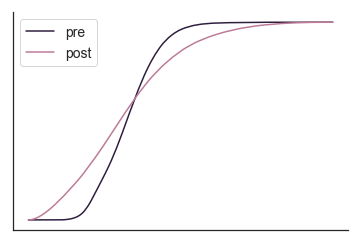

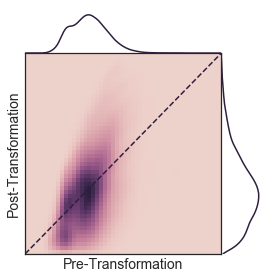

In [32]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [33]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=hemato_10k.uns['pca_distance'], post=hemato_10k.uns['tsne_distance'])

CPU times: user 40.9 s, sys: 2.04 s, total: 43 s
Wall time: 42.4 s


R: 0.4957
EMD: 0.0719
CPU times: user 24.4 s, sys: 1.11 s, total: 25.5 s
Wall time: 25.3 s


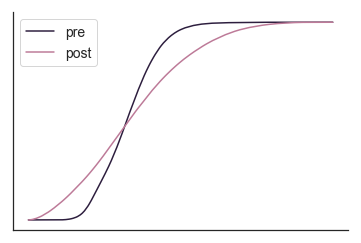

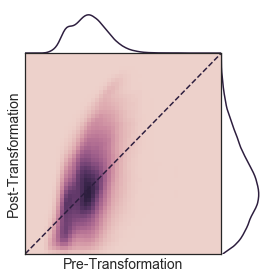

In [34]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

CPU times: user 11.3 s, sys: 2.4 s, total: 13.7 s
Wall time: 12.3 s


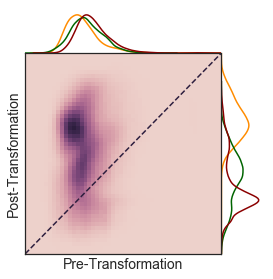

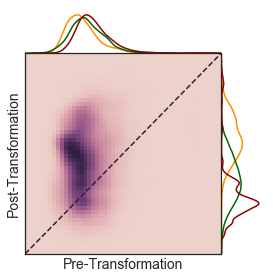

In [125]:
%%time
EMD_umap, corr_stats_umap = cluster_arrangement_sc(adata=hemato_10k, pre=hemato_10k.obsm['X_pca'], post=hemato_10k.obsm['X_umap'], obs_col='louvain_test', IDs=['cluster_0','cluster_4','cluster_5'], ID_names=['cluster_0','cluster_4','cluster_5'], figsize=(4,4), legend=False)
EMD_tsne, corr_stats_tsne = cluster_arrangement_sc(adata=hemato_10k, pre=hemato_10k.obsm['X_pca'], post=hemato_10k.obsm['X_tsne'], obs_col='louvain_test', IDs=['cluster_0','cluster_4','cluster_5'], ID_names=['cluster_0','cluster_4','cluster_5'], figsize=(4,4), legend=False)

---
Samusik_01

In [63]:
sam = sc.read('../inputs/samusik_01.h5ad')

In [65]:
#sc.pp.scale(hemato, max_value=10)
%time sc.tl.pca(sam, use_highly_variable=False, n_comps=10)

CPU times: user 999 ms, sys: 274 ms, total: 1.27 s
Wall time: 134 ms


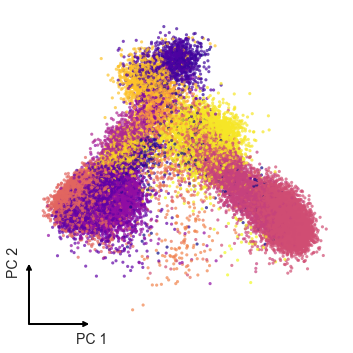

In [66]:
plot_IDs(sam, use_rep='X_pca', obs_col='label', dim_name='PC', pt_size=10)

In [67]:
# create neighborhood graphs from PCA results for UMAP
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(sam, n_neighbors=30, use_rep='X_pca', n_pcs=10, knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


CPU times: user 27.6 s, sys: 93.1 ms, total: 27.7 s
Wall time: 27.7 s


In [68]:
%time sc.tl.umap(sam)

CPU times: user 1min 36s, sys: 2.69 s, total: 1min 38s
Wall time: 1min 7s


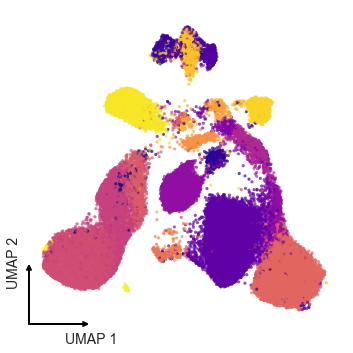

In [69]:
plot_IDs(sam, use_rep='X_umap', obs_col='label', dim_name='UMAP', pt_size=10)

In [87]:
%time sc.tl.tsne(sam)

CPU times: user 11min 21s, sys: 12.4 s, total: 11min 34s
Wall time: 11min 33s


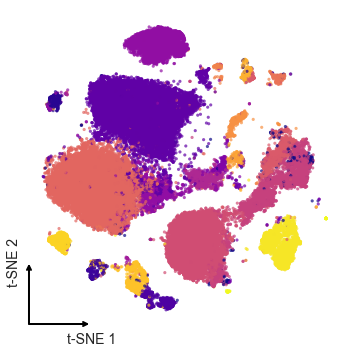

In [91]:
plot_IDs(sam, use_rep='X_tsne', obs_col='label', dim_name='t-SNE', pt_size=10)

In [89]:
sam.write('../inputs/samusik_01_processed.h5ad', compression='gzip')

In [90]:
# first, subsample to reasonable number of obs to get a quick idea of results
sam_10k = sc.pp.subsample(sam, n_obs=10000, random_state=18, copy=True)

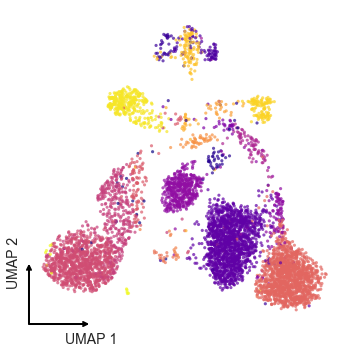

In [93]:
plot_IDs(sam_10k, use_rep='X_umap', obs_col='label', dim_name='UMAP', pt_size=10)

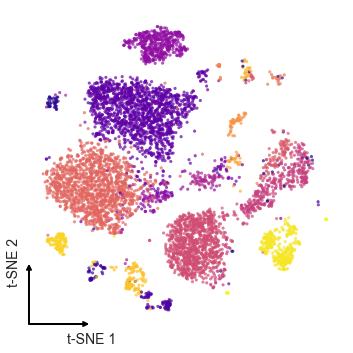

In [94]:
plot_IDs(sam_10k, use_rep='X_tsne', obs_col='label', dim_name='t-SNE', pt_size=10)

In [95]:
%%time
# save distance matrices in AnnData object for easy access
sam_10k.uns['tsne_distance'] = pdist(sam_10k.obsm['X_tsne'])
sam_10k.uns['umap_distance'] = pdist(sam_10k.obsm['X_umap'])
sam_10k.uns['pca_distance'] = pdist(sam_10k.obsm['X_pca'])

CPU times: user 484 ms, sys: 932 µs, total: 485 ms
Wall time: 484 ms


In [96]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=sam_10k.uns['pca_distance'], post=sam_10k.uns['umap_distance'])

CPU times: user 42.1 s, sys: 2.45 s, total: 44.6 s
Wall time: 44.1 s


R: 0.7809
EMD: 0.0417
CPU times: user 25.2 s, sys: 2.05 s, total: 27.2 s
Wall time: 27 s


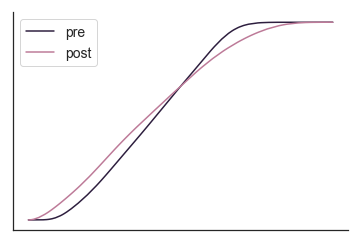

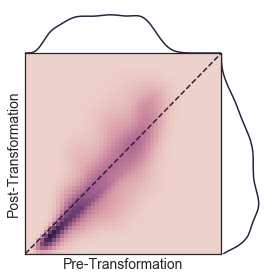

In [97]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

In [98]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=sam_10k.uns['pca_distance'], post=sam_10k.uns['tsne_distance'])

CPU times: user 41.8 s, sys: 2.08 s, total: 43.9 s
Wall time: 43.4 s


R: 0.5285
EMD: 0.0235
CPU times: user 24.7 s, sys: 1.46 s, total: 26.1 s
Wall time: 25.9 s


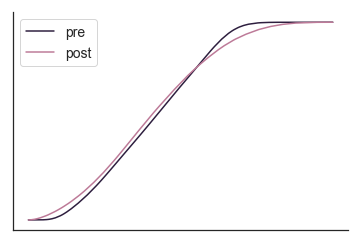

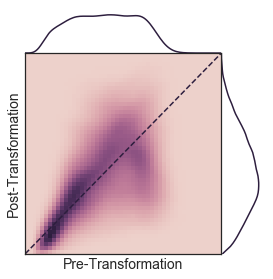

In [99]:
%%time
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

CPU times: user 12.2 s, sys: 569 ms, total: 12.8 s
Wall time: 11.2 s


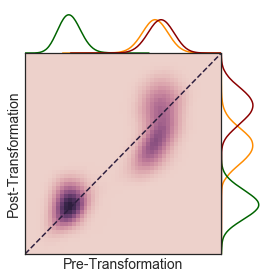

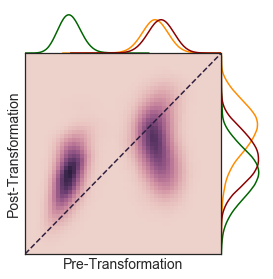

In [114]:
%%time
EMD_umap, corr_stats_umap = cluster_arrangement_sc(adata=sam_10k, pre=sam_10k.obsm['X_pca'], post=sam_10k.obsm['X_umap'], obs_col='label', IDs=[5,13,15], ID_names=['Classical Monocytes','IgD+ IgM+ B cells','Intermediate Monocytes'], figsize=(4,4), legend=False)
EMD_tsne, corr_stats_tsne = cluster_arrangement_sc(adata=sam_10k, pre=sam_10k.obsm['X_pca'], post=sam_10k.obsm['X_tsne'], obs_col='label', IDs=[5,13,15], ID_names=['Classical Monocytes','IgD+ IgM+ B cells','Intermediate Monocytes'], figsize=(4,4), legend=False)

In [100]:
sam_10k.obs['label'].value_counts()

5.0     1550
15.0    1428
13.0    1021
8.0      572
12.0     407
23.0     324
22.0     114
21.0     109
14.0     109
4.0       74
10.0      73
18.0      43
2.0       39
3.0       39
20.0      29
7.0       24
1.0       23
19.0      22
16.0      18
24.0      12
17.0      12
6.0        7
9.0        3
11.0       1
Name: label, dtype: int64

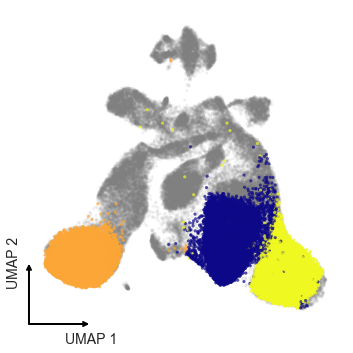

In [112]:
plot_IDs(sam, use_rep='X_umap', obs_col='label', dim_name='UMAP', pt_size=10, IDs=[5,13,15])

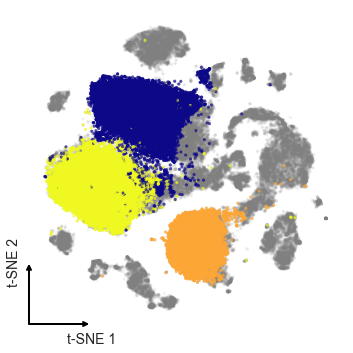

In [113]:
plot_IDs(sam, use_rep='X_tsne', obs_col='label', dim_name='t-SNE', pt_size=10, IDs=[5,13,15])